In [23]:
#Azmain's base code

# Final Plots Displaying Calculated Equivalent Widths and Component Gaussians

import numpy as np
import matplotlib.pyplot as plt
#from specutils.io import read_fits
import pandas as pd
import glob
from lmfit import Model
from astropy.io import fits
from numpy import trapz
from astropy.time import Time
from PyAstronomy import pyasl
from getpass import getuser
from datetime import datetime

print('Working on '+getuser()+'.')

#directories:
#main dir:
gdir='/Users/Cougy/Desktop/_AgnesScottCollege/SummerResearch/2024Summer/' #Dr.-Yep-2024-summer-research/'
#Goodman normalized spectra:
gndir=gdir+'/GoodmanNormBest/'

#open normalized data, return w,f norm, f wfun (unnormalized, for sigmav),head,bcv:
def opfitsg(name):
    print('returns: w,f,fun,head,bc')
    # One target against one standard:
    #def fitvsinilite(name,stdname,rvcent0=0,vsinistart0=0,skipedge0=0,prin='n',plotyn='n',pltcc='n'): #returns the essentials.
    #For standards test, you don't account for each standard's uncert.
    #target:
    hdu=fits.open(gndir+'n_'+name+'.fits') #.fits data
    dat=hdu[0].data
    head=hdu[0].header
    hdu.close()
    bc=bcvg(head) #barycentric correction
    w,f=dat #total spectrum
    #unnorm for sigmav
    wfunfile=head['WFUNFILE']
    hdu=fits.open(gdir+wfunfile) #.fits data
    fun=hdu[0].data[1] #unnorm spectrum
    hdu.close()
    return w,f,fun,head,bc

#Ultimate opendat:
def opendatt(dir,filename,spl=''): #dir,'filename'. For opening a data file. Can then send through roundtable.
    f=open(dir+filename,'r')
    dat=f.readlines()
    f.close()
    if spl=='':
        labels=dat[0][0:-1].split()
        dat2=[[a.strip('\n') for a in d.split()] for d in dat if d[0]!='#']
    else:
        labels=dat[0][0:-1].split(spl)
        dat2=[[a.strip('\n') for a in d.split(spl)] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]

def opendat(dirr,filename,params,splitchar='\t',prin='y'): #Use as var,var,var...=opendat(dir,'filename',['keys']).
    if splitchar=='':
        dat,label=opendatt(dirr,filename)
    else:
        dat,label=opendatt(dirr,filename,splitchar)  #Get keys by first leaving ['keys'] blank: opendat(dirr,filename,[])
    if prin=='y':
        print(label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    if len(params)==1:
        varrs=varrs[0]
    return varrs

def writedat(dirr,filename,pars,label): #.dat auto included. pars as [name,ra,dec] etc.
    datp=[[str(a[i]) for a in pars] for i in range(len(pars[0]))]
    f=open(dirr+filename+'.dat','w')
    print('\t'.join(label),file=f)
    print(label)
    for d in datp:
        print('\t'.join(d),file=f)
    f.close()
    print('It is written: '+filename+'.dat')
    
#mini normalizer
def smooth(w,f,wc,fc,deg):
    #Fit polynomial to cut spectra.
    Ac = np.zeros((len(wc),2)) 
    Ac[:,0] = wc 
    Ac[:,1] = fc 

    xc = Ac[:,0] 
    yc = Ac[:,1] 
    zc = np.polyfit(xc,yc,deg)
    #print(zc)
    pc = np.poly1d(zc)
    
    D = np.zeros((len(w),2)) 
    D[:,0] = w
    D[:,1] = f
    x = D[:,0]
    y = D[:,1]
    return pc(x)
    
def sigmavg(dat,head,w,f,fn): #fits data, fits header, wavelength, unnormalized flux, normalized flux; Goodman
    #w,f=wf(dat,o)
    gain=float(head['GAIN'])
    RN=float(head['RDNOISE'])
#     if head['MODES'].split(',')[int(head['MODE'])].strip()=='fiber':
#         K=2.5
#     elif head['MODES'].split(',')[int(head['MODE'])].strip()=='slicer':
#         K=9.
    K=5 #pixels binned across spectral order. Here, it's...? No clue.
    SNR=np.array(f)*gain/np.sqrt(np.array(f)*gain+K*RN**2.)
    c=299792.458 #km/s
    dfdw=deriv(w,fn)
    Sigmav=1./np.sqrt(np.nansum((np.array(dfdw)*np.array(w)*np.array(SNR)/c)**2.))
    return Sigmav

#By chain rule: df/dv = df/dw * w/c. So can use df/dw derivative and multiply by w/c for deriv at each pixel.
def deriv(X,Y): #numerical
    #middle: 2 derivs on either side of pixel, then average
    x0=np.array(X[:-2])
    y0=np.array(Y[:-2])
    x1=np.array(X[1:-1])
    y1=np.array(Y[1:-1])
    x2=np.array(X[2:])
    y2=np.array(Y[2:])
    dydx_m=((y1-y0)/(x1-x0)+(y2-y1)/(x1-x0))/2.
    #print(len(dydx_m))
    #ends: just do 1 deriv
    dydx_b=(Y[1]-Y[0])/(X[1]-X[0])
    dydx_e=(Y[-1]-Y[-2])/(X[-1]-X[-2])
    #combine:
    dydx=[dydx_b,]+list(dydx_m)+[dydx_e,]
    #print(len(dydx))
    return dydx

#For weighting results:
#By chain rule: df/dv = df/dw * w/c. So can use df/dw derivative and multiply by w/c for deriv at each pixel.

#barycentric correction
def bcvg(head): #for Goodman
    #RA,Dec,expt,jd (jd of middle of exposure time)

    # Coordinates of SOAR telescope for Goodman
    longitude = -1.*(70.+44./60.+1.11/3600.) #degrees, E=+,W=-
    latitude = -30.-14./60.-16.41/3600. #degrees
    altitude = 2713. #meters
    
    expt=head['EXPTIME'] #exposure time
    #print(expt,type(expt),type(Time(head['DATE-OBS']).jd))
    JD=Time(head['DATE-OBS']).jd+expt/2./60./24. #Julian day of middle of exposure, UT
    # Coordinates in degrees (J2000) for pyas1
    RA=[float(d)*15. for d in head['RA'].split(':')] #RA, degrees
    DEC=[float(d) for d in head['DEC'].split(':')] #Dec
    if '-' in head['DEC']:
        sign=-1.
    else:
        sign=1.
    ra2000 = RA[0]+RA[1]/60.+RA[2]/3600. #RA
    dec2000 = sign*(abs(DEC[0])+DEC[1]/60.+DEC[2]/3600.) #Dec

    # Barycentric velocity correction
    cor = pyasl.helcorr(longitude, latitude, altitude,ra2000, dec2000, JD)[0]
    return cor

def gaussian(x, amp, cen, wid): # Gaussian model
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return ((1 * amp) / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2)) 
gmodel = Model(gaussian)

#new sval 2024 (allow IV), let's try only up to K7, rest go to "10" to change class. K7 goes to "8."
def sval(ss): #'spt'
    def vs(s): #v from s, for single value
        if s=='nan':
            v= np.float('nan')
            return np.float('nan')
        else:
            val=60-['O','B','A','F','G','K','M','L','T','Y'].index(s[0])*10+(10-float(s[1:].strip('V').strip('I')))
        if s[0] in ['M','L','T','Y']: #M gets set back because of K; K7 should be right next to M0
            val+=2
        if 'III' in s:
            v= val-100.
        elif 'I' in s and 'III' not in s and 'V' not in s:
            v= val-200.
        else:
            v= val
        return v
    if type(ss)==str:
        final=vs(ss)
    if type(ss)==list or type(ss)==type(np.array([1])):
        final=[]
        for i in range(len(ss)):
            s=ss[i]
            v=vs(s)
            final.append(v)
    return final

def sptfromsval(s): #'spt'
    obafgkm=['O','B','A','F','G','K','M']
    if s<=12:
        s-=2 #handle the Ms
    if s>=0:
        lum='V'
        S=int(s/10.)
    elif s<0 and s>=-100:
        lum='III'
        S=int((s+100.)/10.)
    elif s<-100:
        lum='I'
        S=int((s+200.)/10.)
    else:
        print('Error with luminosity class.')
    clas=str(round(10-(s-float(10*S)),1)).replace('.0','')
    if round(10-(s-float(10*S)),1)==10:
        clas='0'
        S-=1
    oba=obafgkm[6-S]
    return oba+clas+lum

#retrieve rv,vsini,bcv from LogCruncher standards summary file
def refv(stdname):
    name,vsini,vsinierr,rv,rverr=opendat(cdir,'standards/standards_metadata.dat',['#name','vsini', 'vsinierr', 'rv', 'rverr'],splitchar='\t',prin='n')
    #bname,barycorr=opendat2(cdir,'standards/CHIRON_standards_bestobs.dat',['name','barycorr'])
    i=name.index(stdname)
    #j=bname.index(stdname)
    return vsini[i],vsinierr[i],rv[i],rverr[i]

def refspt(stdname):
    name,spt=opendat(cdir,'standards/standards_metadata.dat',['#name','spt'],splitchar='\t',prin='n')
    i=name.index(stdname)
    return spt[i]

# namervs,rvs,rverrs,cgrvs,vsinis=opendat2(ddir,'CG_rvs.dat',['#name','rv','rverr','CG','vsini'])
# namespts,spts=opendat2(cdir,'CGs/CGs_SpTGuess.dat',['#name','SpTGuess'])
# CGt,t=opendat2(ddir,'CG_properties.dat',['#CG','Myr'])

Working on Cougy.


In [35]:
#mix
c0,af0,aferr0,t0,terr0,radenv0=opendat('','accfrac_2020.dat',['#cluster', 'accfrac', 'accfrac_err', 'age', 'ageerr','radenv'])
cq,afq,aferrq,tq,terrq,radenvq=[[l[i] for i in range(len(c0)) if radenv0[i]=='q'] for l in [c0,af0,aferr0,t0,terr0,radenv0]]
cir,afir,aferrir,tir,terrir,radenvir=[[l[i] for i in range(len(c0)) if radenv0[i]=='ir' and c0[i]!='CG30'] for l in [c0,af0,aferr0,t0,terr0,radenv0]]
print(cq)
print(cir)
#all irr
c4,af4,aferr4,t4,tperr4,tmerr4=opendat('','accfrac_2024.dat',['#cluster', 'accfrac', 'accfrac_err', 'age', 'ageerr(+)','ageerr(-)'])

terr4=[np.mean([tperr4[i],tmerr4[i]]) for i in range(len(c4))]
print(terr4)

['#cluster', 'accfrac', 'accfrac_err', 'age', 'ageerr', 'radenv']
['rho Oph', 'Tau-Aur', 'IC348', 'Lup', 'Cha I']
['L1641', 'ONC', 'L1615/1616', 'Tr 37', 'NGC 1977/1980', 'Ori', 'Upper Sco']
['#cluster', 'numtot', 'numacc', 'accfrac', 'accfrac_err', 'age', 'ageerr(+)', 'ageerr(-)']
[3.5, 1.75, 6.5, 3.0, 4.5, 37.5, 12.5]


[1.  2.  2.  2.5 2.5] [50. 59. 59. 33. 33.] [16.  9.  9.  6.  6.]
[ 3.9   6.55  8.5  13.   13.   32.5  49.  ] [95.46153846 70.71428571 60.83333333 29.63934426 29.63934426  7.
 33.9       ] [22.2005229  18.97191412 14.31694991  8.63934426  8.63934426  2.
  3.1       ]


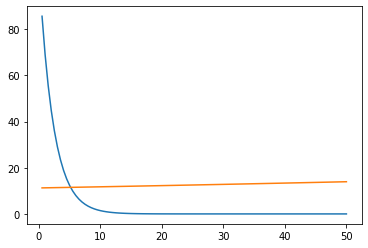

In [40]:
xa=np.arange(0.5,50.5,0.5)

#quiescent
af,aferr,age=np.array(afq),np.array(aferrq),np.array(tq)
isort=np.array([list(age).index(a) for a in sorted(age)])
print(age[isort],af[isort],aferr[isort])
x,y,ww=age[isort],af[isort],aferr[isort]
x,y,ww=np.array([0.]+list(age[isort])),np.array([100.]+list(af[isort])),[np.mean(aferr)]+list(aferr[isort])
z=np.polyfit(x,np.log10(y),1,w=1./np.array(ww))
pn = np.poly1d(z)
plt.plot(xa,10.**pn(xa))

#irradiated
af,aferr,age=np.array(afir+af4),np.array(aferrir+aferr4),np.array(tir+t4)
isort=np.array([list(age).index(a) for a in sorted(age)])
print(age[isort],af[isort],aferr[isort])
x,y,ww=age[isort],af[isort],aferr[isort]
x,y,ww=np.array([0.]+list(age[isort])),np.array([100.]+list(af[isort])),[np.mean(aferr)]+list(aferr[isort])
z=np.polyfit(x,np.log10(y),1,w=1./np.array(ww))
py = np.poly1d(z)
plt.plot(xa,10.**py(xa))

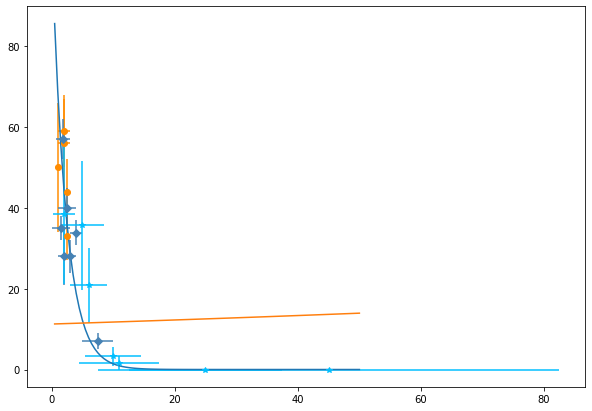

In [41]:
plt.figure(figsize=(10,7))
#Previous Data, sans CG30
plt.errorbar(tq,afq,aferrq,terrq,ls='',color='darkorange',marker='o')
plt.errorbar(tir,afir,aferrir,terrir,ls='',color='steelblue',marker='D')

#Goodman Data
plt.errorbar(t4,af4,aferr4,terr4,ls='',color='deepskyblue',marker='*')

#fits
plt.plot(xa,10.**pn(xa))
plt.plot(xa,10.**py(xa))